In [1]:
#Remove 3 in "pip3" if conda pip installed
try:
    import openfermion
except ImportError:
    !pip3 install git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
from numpy import random
import cmath
import time
from sympy import S, symbols, printing

from compilers import TrotterSim
from compilers import QDriftSimulator
from compilers import CompositeSim

 ### Hamiltonian Initialization

#### Arbitrary Tensored 4x4 Pauli

In [2]:
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
Y = np.array([[0, -1j],
     [1j, 0]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)
IZ = np.kron(I, Z)
ZI = np.kron(Z, I)

In [3]:
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX, IZ, XI, ZI])
hj = [1.0, 2.0, 3.0, 4.0, 2.0, 1.0, 0.5, 0.25] #list of normalized coefficients

print(Hlist.shape)

hamiltonian_list = []
for i in range(len(hj)):
    hamiltonian_list.append(hj[i] * Hlist[i, :, :]);
hamiltonian_list = np.array(hamiltonian_list)
print(hamiltonian_list.shape)
#print(hamiltonian_list)

(8, 4, 4)
(8, 4, 4)


#### Graph Hamiltonian

In [71]:
def dist(site1, site2):
    distance_vec = site1 - site2
    distance = np.abs(distance_vec[0]) + np.abs(distance_vec[1])
    return distance

def initialize_graph(x_sites, y_sites):
    coord_list = []
    for i in range(x_sites):
        for j in range(y_sites):
            coord_list.append([i,j])
    return np.array(coord_list)

def initialize_operator(operator_2d, acting_space, space_dimension):
    if acting_space>space_dimension:
        return 'error'
    for i in range(acting_space):
        operator_2d = np.kron(operator_2d, I)
    for j in range(space_dimension - acting_space-1):
        operator_2d = np.kron(I, operator_2d)
    return operator_2d

In [72]:
#Tests
graph = initialize_graph(3,2)
print(graph)
print(dist(graph[0], graph[2]))
op = initialize_operator(Z, 0 , 2)
print(op)

[[0 0]
 [0 1]
 [1 0]
 [1 1]
 [2 0]
 [2 1]]
1
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0  1  0]
 [ 0  0  0 -1]]


In [73]:
#Initialize Hamiltonian 
def graph_hamiltonian(x_dim, y_dim, rng_seed):
    np.random.seed(rng_seed)
    hamiltonian_list = []
    graph = initialize_graph(x_dim, y_dim)
    for i in range(x_dim*y_dim):
        for j in range(y_dim*x_dim):
            if i != j:
                alpha = np.random.normal()
                hamiltonian_list.append(alpha * 
                    np.matmul(initialize_operator(Z, i, x_dim*y_dim), initialize_operator(Z, j, x_dim*y_dim)) *
                        10.0**(-dist(graph[i], graph[j])))
            
        alpha = np.random.normal()
        hamiltonian_list.append(4* alpha * initialize_operator(X, i, x_dim*y_dim))
                
    return np.array(hamiltonian_list)

graph_hamiltonian_list = graph_hamiltonian(4, 2, 1)
print(graph_hamiltonian_list.shape)

(64, 256, 256)


#### Jellium Hamiltonian

In [ ]:
from openfermion.hamiltonians import jellium_model
from openfermion.utils import Grid
from openfermion.linalg import eigenspectrum
from openfermion.transforms import jordan_wigner, fourier_transform

#small model in 2 dimensions
grid = Grid(dimensions=2, length=3, scale=1.0)
spinless = True

# Get the momentum Hamiltonian.
momentum_hamiltonian = jellium_model(grid, spinless)
momentum_qubit_operator = jordan_wigner(momentum_hamiltonian)
momentum_qubit_operator.compress()
print(momentum_qubit_operator)

## Notebook using compilers.py

The goal is to compare the functions in compilers.py to the ones witten here in both output and runtimes. The only part of the previous sections that this section will reference is "Hamiltonian Initialization"

### Trotter Simulation

In [77]:
#Example, does not need to be run
#use array hamiltonian_list
sim = TrotterSim([np.array([[0,1], [1,0]])])
print(sim.simulate(np.pi / 2, 4)) #output state should be sigma_X |0> = |1>

[0.92387953+0.j         0.        +0.38268343j]


In [44]:
sim1 = TrotterSim(hamiltonian_list, 6)
#sim1.initial_state = InitialState

In [105]:
startTime = time.time()

iterations = 1
tStart = 0.01
tFinal = 0.1
tSteps = 50
times = np.geomspace(tStart, tFinal, tSteps)

trot_compiler_inf = []
for t in times:
    trot_compiler_inf.append(sim1.infidelity(t, iterations))

log_trot_compiler_inf = np.log10(trot_compiler_inf)
log_times = np.log10(times)
print(log_trot_compiler_inf.shape)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

(50,)
Execution time in seconds: 4.199537992477417


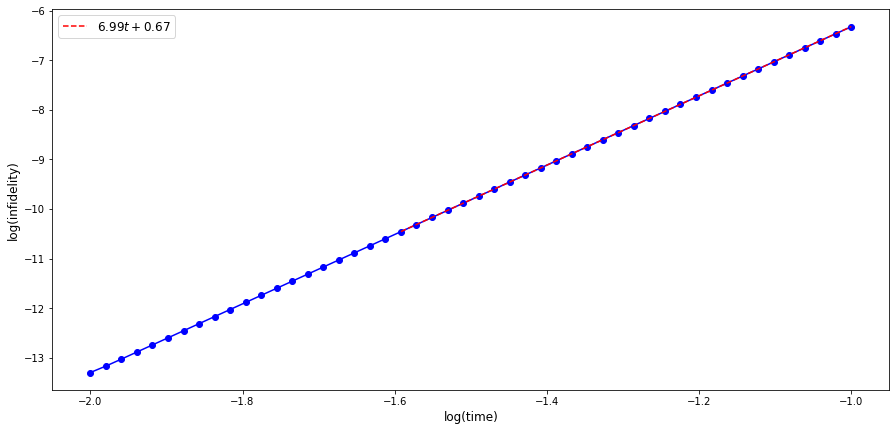

In [106]:
#data = log_trot_compiler_inf[:, 0, 0]
data = log_trot_compiler_inf
plt.figure(figsize = (15, 7))
plt.plot(log_times, data, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points= 20  #declare the starting point to fit in the data
end_fit_points = -1

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

### QDrift Simulation

In [97]:
QDsim = QDriftSimulator(hamiltonian_list)
QDsim.simulate(1, 1000)

array([ 0.01713949+0.825171j  , -0.24180231+0.41591016j,
       -0.03865737-0.06627492j, -0.0062236 -0.28534882j])

In [98]:
QDsim.sample_channel_inf(1, 1, 40)

0.5932620415664414

In [99]:
startTime = time.time()

tStart = 0.0001
tFinal = 0.05
tSteps = 100
times = np.geomspace(tStart, tFinal, tSteps) 

qd_compiler_inf = []
for t in times:
    qd_compiler_inf.append(QDsim.sample_channel_inf(t, 10, 200))

log_qd_compiler_inf = np.log10(qd_compiler_inf)
log_times = np.log10(times)
print(log_qd_compiler_inf.shape)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

(100,)
Execution time in seconds: 51.75785493850708


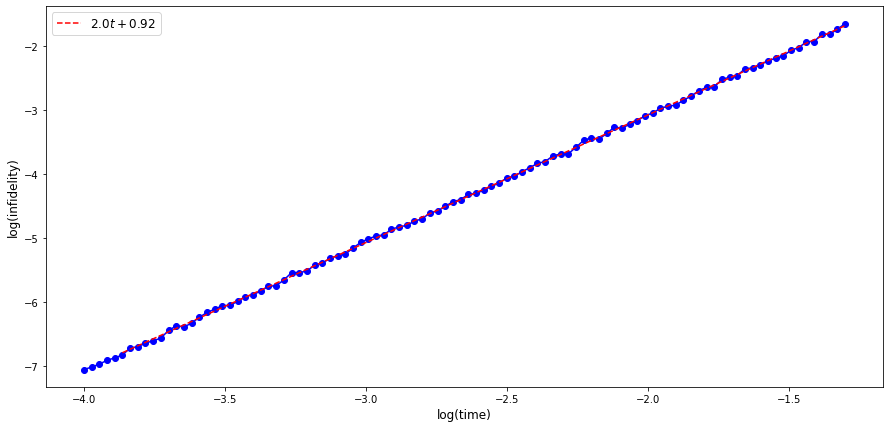

In [102]:
data1 = log_qd_compiler_inf #[:, 0, 0]
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 5 #declare the starting point to fit in the data

p = np.polyfit(log_times[fit_points: -1], data1[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[fit_points], log_times[-1], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

### Composite Simulation

In [145]:
#Warning if nb_optimizer = True for partition attribute optimize the computation will not finish in your lifetime
CompSim = CompositeSim(hamiltonian_list, inner_order=4, outter_order=1, partition = "trotter", repartition = False, rng_seed = 30, weight_threshold = 0.5, nb = 1, nb_optimizer = False, initial_time = 1.2)
#CompSim.simulate(0.1, 70, 4)

There are 8 terms in Trotter
There are 0 terms in QDrift


In [146]:
startTime = time.time()

iterations = 100
qd_samples = 1
mc_samples = 1

tStart = 1
tFinal = 5
tSteps = 40
times = np.geomspace(tStart, tFinal, tSteps)

comp_compiler_inf = []
for t in times:
    comp_compiler_inf.append(CompSim.sample_channel_inf(t, qd_samples, iterations, mc_samples))

log_comp_compiler_inf = np.log10(comp_compiler_inf)
log_times = np.log10(times)
print(log_comp_compiler_inf.shape)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

(40, 1, 1)
Execution time in seconds: 74.93746590614319


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


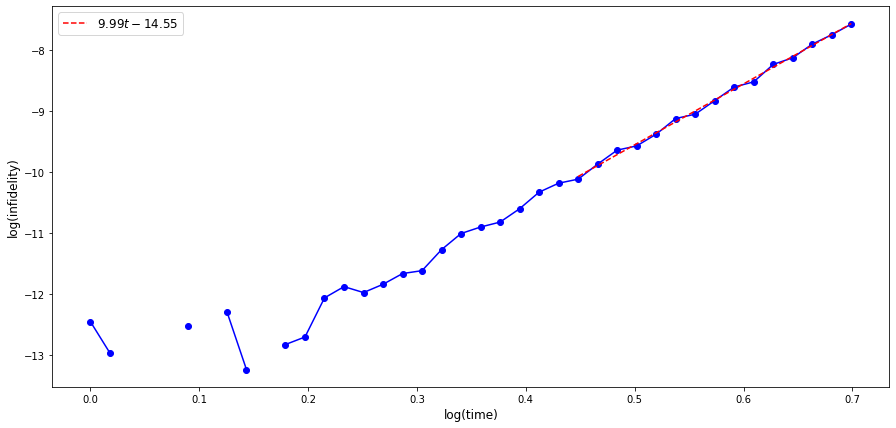

In [147]:
#print(list(log_comp_compiler_inf[:, 0, 0]))
data1 = log_comp_compiler_inf[:, 0, 0] #this dimension issue might be causing some slow down
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points=25  #declare the starting point to fit in the data
end_fit_points = -1

p = np.polyfit(log_times[start_fit_points: end_fit_points], data1[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

#plt.ylim(-1.1, -0.8)
#plt.locator_params('x', nbins=20)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [20]:
t = 0.5 
samples = 4
iterations = 1
mcsamples = 40

startTime = time.time()
#Test function sim_channel_performance
CompSim1 = CompositeSim(hamiltonian_list, inner_order = 2, partition = "optimize", rng_seed = 9, nb_optimizer = False, weight_threshold = 0.5, epsilon = 0.001, repartition = False)
#CompSim1.simulate(0.1, 10, 10, False, False)
data2 = CompSim1.sim_channel_performance(t, samples, iterations, mcsamples)
print('We require ' + str(data2)  +' gates to meet an epsilon of ' + str(CompSim1.epsilon))
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

[1.         0.99999555 1.         0.89325134 1.         0.
 1.         0.        ]
There are 6 terms in Trotter
There are 2 terms in QDrift
[[3.52000000e+02 1.57198356e-03]
 [3.84000000e+02 1.43422721e-03]
 [4.16000000e+02 1.51590393e-03]
 [4.48000000e+02 1.06850989e-03]
 [4.80000000e+02 1.24906660e-03]
 [5.12000000e+02 1.01114983e-03]
 [5.44000000e+02 9.46432125e-04]
 [5.76000000e+02 1.18059305e-03]
 [6.08000000e+02 7.17405976e-04]
 [6.40000000e+02 9.71691726e-04]]
We require 545.3098239669162 gates to meet an epsilon of 0.001
Execution time in seconds: 51.539170026779175


In [18]:
#Testing for single times, potentially test convergence of mc_samples below

CompSim1.sample_channel_inf(t, samples, iterations, mcsamples)

array([[0.00089707]])

#### Channel Gate Performance

In [10]:
1/ 2 - 1

-0.5